**Import Necessary Libraries**

In [1]:
import os
import glob
import numpy as np
from pathlib import Path

from matplotlib.image import imread
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import warnings
warnings.filterwarnings('ignore')

Dataset Link: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip

**Define Configuration Options**

In [2]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

**Load Images using `ImageGeneratorClass`**

In [3]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


**Create `test_generator` using `test_datagen` Object**

In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    class_mode = 'binary',
    seed = seed,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


**Display Few Augmented Images**

Labels: ['O', 'O', 'O', 'O', 'O']


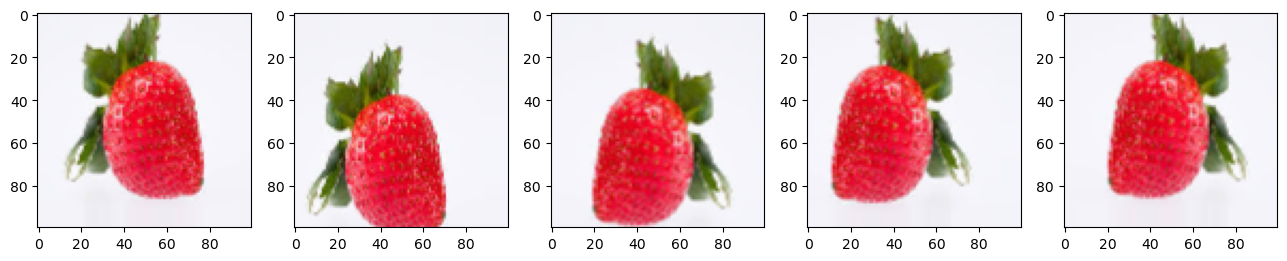

In [7]:
IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1], batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

**Pre-trained Model: VGG16**

In [8]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [9]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

**Freeze Base Model**

In [10]:
for layer in basemodel.layers: 
    layer.trainable = False

**Create New Model on top**

In [11]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 4,457,985
Non

**Compile Model**

In [12]:
for layer in basemodel.layers: 
    layer.trainable = False

# Compile the model
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(learning_rate=1e-4),
    metrics = ['accuracy']
)

**Early Stopping**

In [13]:
checkpoint_path='O_R_tlearn_vgg16.keras'

# Define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# Learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

**Fit and Train Model**

In [14]:
extract_feat_model = model.fit(train_generator, steps_per_epoch = 5, epochs = 10, callbacks = callbacks_list_,   
                               validation_data = val_generator,  validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 [==============================] - 9s 2s/step - loss: 0.6675 - accuracy: 0.6313 - val_loss: 0.5663 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 0.5360 - accuracy: 0.7500 - val_loss: 0.5321 - val_accuracy: 0.6875 - lr: 9.0484e-05
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 0.5361 - accuracy: 0.7437 - val_loss: 0.4338 - val_accuracy: 0.8385 - lr: 8.1873e-05
Epoch 4/10
5/5 [==============================] - 8s 2s/step - loss: 0.4309 - accuracy: 0.8188 - val_loss: 0.3941 - val_accuracy: 0.8281 - lr: 7.4082e-05
Epoch 5/10
5/5 [==============================] - 8s 2s/step - loss: 0.4705 - accuracy: 0.7500 - val_loss: 0.3933 - val_accuracy: 0.8438 - lr: 6.7032e-05
Epoch 6/10
5/5 [==============================] - 8s 2s/step - loss: 0.4363 - accuracy: 0.8125 - val_loss: 0.3712 - val_accuracy: 0.8281 - lr: 6.0653e-05
Epoch 7/10
5/5 [==============================] - 8s 2s/step - loss: 0.4001 

**Plot Loss Curves for Training and Validation Sets (`extract_feat_model`)**

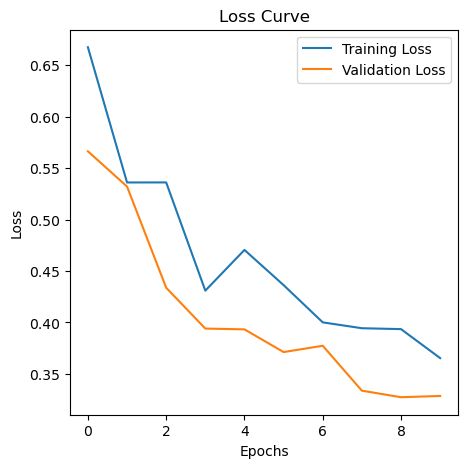

In [15]:
history = extract_feat_model

# Plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Plot Accuracy Curves for Training and Validation Sets (`extract_feat_model`)**

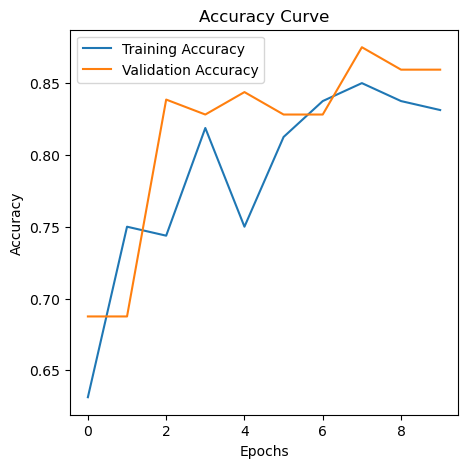

In [16]:
history = extract_feat_model

# Plot accuracy curve  
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Fine-Tuning Model**

In [17]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


**Create New Model on Top and Add Dropout Layer for Regularization**

In [18]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# Learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', patience = 4, mode = 'min', min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, steps_per_epoch = 5, epochs = 10, callbacks = callbacks_list_,   
                    validation_data = val_generator, validation_steps = val_generator.samples // batch_size, 
                    verbose = 1)

Epoch 1/10
5/5 [==============================] - 11s 2s/step - loss: 0.6579 - accuracy: 0.6125 - val_loss: 0.5413 - val_accuracy: 0.7552 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 0.5559 - accuracy: 0.7250 - val_loss: 0.4648 - val_accuracy: 0.8073 - lr: 9.0484e-05
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 0.5199 - accuracy: 0.7688 - val_loss: 0.4280 - val_accuracy: 0.8073 - lr: 8.1873e-05
Epoch 4/10
5/5 [==============================] - 10s 2s/step - loss: 0.4858 - accuracy: 0.7625 - val_loss: 0.3542 - val_accuracy: 0.8750 - lr: 7.4082e-05
Epoch 5/10
5/5 [==============================] - 10s 2s/step - loss: 0.3912 - accuracy: 0.8125 - val_loss: 0.3401 - val_accuracy: 0.8542 - lr: 6.7032e-05
Epoch 6/10
5/5 [==============================] - 10s 2s/step - loss: 0.3771 - accuracy: 0.8313 - val_loss: 0.3082 - val_accuracy: 0.8958 - lr: 6.0653e-05
Epoch 7/10
5/5 [==============================] - 10s 2s/step - loss: 0.

**Plot Loss Curves for Training and Validation Sets (`fine_tune_model`)**

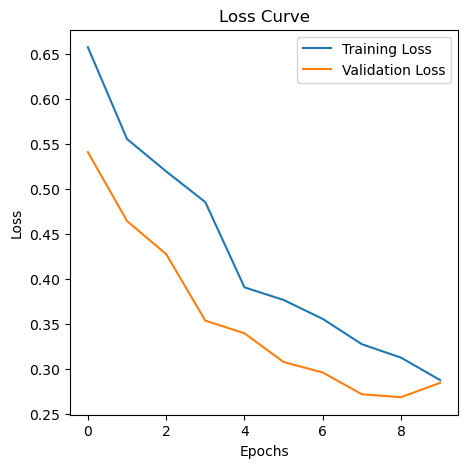

In [19]:
history = fine_tune_model

## Plot loss curves
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Plot Accuracy Curves for Training and Validation Sets (`fine_tune_model`)**

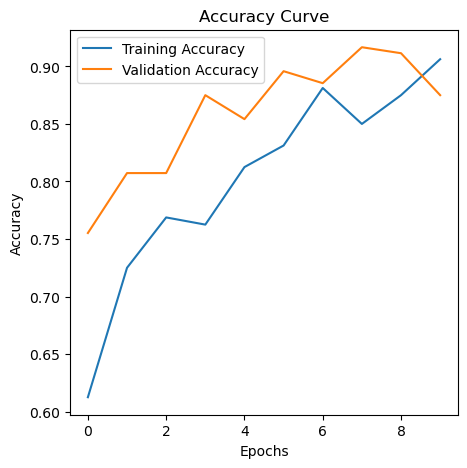

In [20]:
history = fine_tune_model

# Plot accuracy curves
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Evaluate Both Models on Test Data**

In [21]:
# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.73      0.92      0.81        50
           R       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.78      0.86      0.82        50
           R       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



**Plot One of the Images with Actual Label and Predicted Label as Title**

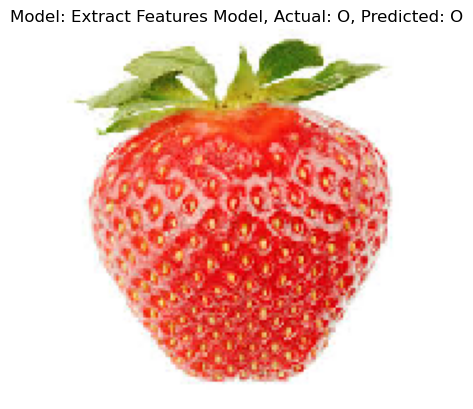

In [22]:
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    
# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
)

**Plot Test Image using Extract Features Model**

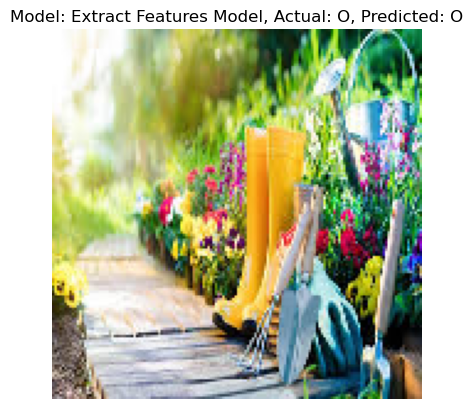

In [23]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
)

**Plot Test Image using Fine-Tuned Model**

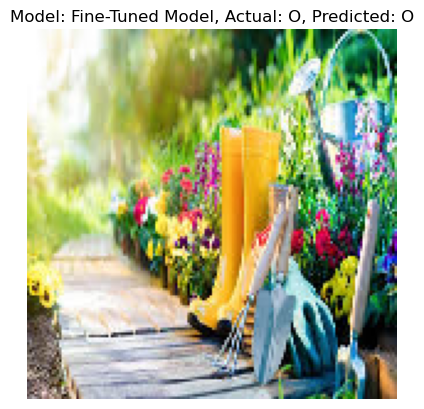

In [24]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_fine_tune_model[index_to_plot],
)